Loading data...
id        0
cat_0     0
cat_1     0
cat_2     0
cat_3     0
cat_4     0
cat_5     0
cat_6     0
cat_7     0
cat_8     0
cat_9     0
cat_10    0
cat_11    0
cat_12    0
cat_13    0
cat_14    0
cat_15    0
cat_16    0
cat_17    0
cat_18    0
cat_19    0
num_0     0
num_1     0
num_2     0
num_3     0
num_4     0
num_5     0
num_6     0
num_7     0
num_8     0
num_9     0
num_10    0
num_11    0
num_12    0
num_13    0
num_14    0
num_15    0
num_16    0
num_17    0
num_18    0
num_19    0
num_20    0
num_21    0
num_22    0
num_23    0
num_24    0
num_25    0
num_26    0
num_27    0
num_28    0
num_29    0
num_30    0
num_31    0
num_32    0
num_33    0
num_34    0
num_35    0
num_36    0
num_37    0
target    0
dtype: int64
Data Loading Time: 2.81 seconds
Preprocessing data...
Data Preprocessing Time: 7.03 seconds
Starting Particle Swarm Optimization...
[LightGBM] [Info] Number of positive: 8453, number of negative: 631547
[LightGBM] [Info] Auto-choosing row-wise multi-t

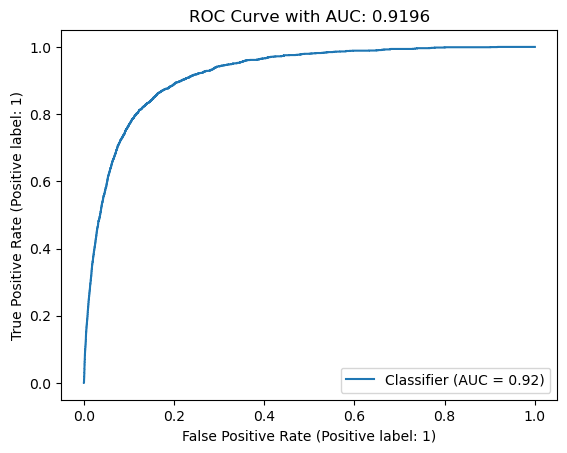

Total Run Time: 889.40 seconds


In [1]:
# Ensure pyswarm is installed
!pip install pyswarm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, RocCurveDisplay, classification_report, accuracy_score
from lightgbm import LGBMClassifier, early_stopping
from pyswarm import pso

# Record start time
start_time = time.time()

print("Loading data...")
# Load dataset
data = pd.read_csv('train.csv')

# Check for missing values
print(data.isnull().sum())

# Record data loading time
data_loading_time = time.time()
print(f'Data Loading Time: {data_loading_time - start_time:.2f} seconds')

print("Preprocessing data...")
# Define categorical and numerical features
cat_features = [f'cat_{i}' for i in range(20)]
num_features = [f'num_{i}' for i in range(38)]

# Data preprocessing pipelines
# For numerical features: impute missing values and scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values and one-hot encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Apply the preprocessing pipelines to the corresponding columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Split the dataset into features and target variable
X = data.drop(['id', 'target'], axis=1)
y = data['target']

# Apply preprocessing to the dataset
X_processed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Record data preprocessing time
data_preprocessing_time = time.time()
print(f'Data Preprocessing Time: {data_preprocessing_time - data_loading_time:.2f} seconds')

# Define the objective function for Particle Swarm Optimization (PSO)
def lgb_eval(params):
    max_depth, num_leaves, n_estimators = params
    params = {
        'max_depth': int(max_depth),
        'num_leaves': int(num_leaves),
        'n_estimators': int(n_estimators),
        'objective': 'binary',
        'metric': 'auc'
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[early_stopping(stopping_rounds=10)])
    y_pred = model.predict_proba(X_test)[:, 1]
    return -roc_auc_score(y_test, y_pred)  # PSO minimizes, so return negative AUC

# Define the parameter bounds for PSO
lb = [5, 20, 50]  # Lower bounds for max_depth, num_leaves, n_estimators
ub = [20, 100, 300]  # Upper bounds for max_depth, num_leaves, n_estimators

# Execute Particle Swarm Optimization
print("Starting Particle Swarm Optimization...")
best_params, best_score = pso(lgb_eval, lb, ub, swarmsize=10, maxiter=10)

# Train the model with the best parameters found by PSO
best_params = {
    'max_depth': int(best_params[0]),
    'num_leaves': int(best_params[1]),
    'n_estimators': int(best_params[2])
}

print(f"Training the best model with params {best_params}...")
model = LGBMClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred >= 0.5).astype(int)
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

print(f'Best Model with params {best_params} has ROC AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

# Plot ROC curve
print("Plotting ROC curve...")
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title(f'ROC Curve with AUC: {roc_auc:.4f}')
plt.show()

# Record end time and calculate total run time
end_time = time.time()
run_time = end_time - start_time
print(f'Total Run Time: {run_time:.2f} seconds')